<a href="https://colab.research.google.com/github/Muhirwakyeyune/AMMI-NATURAL-LANGUAGE-PROCESSING/blob/main/Muhirwa_Salomon_AMMI23_lab_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N-Gram Language Modeling

In **language modeling** we want to model the probability of variable length sequences, $$\large p(w_1,\ldots,w_T)=\prod_{t=1}^T p(w_t|w_{<t}).$$

An **n-gram language model** assumes that each word $w_t$ only depends on the preceding $n-1$ words(prefix), $$\large p(w_1,\ldots,w_T)=\prod_{t=1}^T p(w_t|w_{t-n+1},\ldots,w_{t-1}).$$



#### Example
For instance, when modeling the sentence $$\texttt{the cat sat on the mat .}$$ a 3-gram language model assumes that $$p(\texttt{mat}|\texttt{the cat sat on the}) \approx p(\texttt{mat}|\texttt{on the}).$$

The sub-sequence $(\texttt{on the mat})$ is a *3-gram* or *trigram*.

### Count-based Estimation

Given some dataset $D$ of sequences, we can estimate an n-gram model through counting, derived as follows:

\begin{align}
p(w_t|w_{t-n+1},\ldots,w_{t-1}) &= \frac{p(w_{t-n+1},\ldots,w_{t-1},w_t)}{p(w_{t-n+1},\ldots,w_{t-1})} & \text{definition of conditional probability}\\
                       &= \frac{p(w_{t-n+1},\ldots,w_{t-1},w_t)}{\sum_{w_{t'}}p(w_{t-n+1},\ldots,w_{t-1},w_{t'})}\\
                       &\approx \frac{\frac{1}{N}\text{count}(w_{t-n+1},\ldots,w_{t-1},w_t)}{\frac{1}{N}\sum_{w_{t'}}\text{count}(w_{t-n+1},\ldots,w_{t-1},w_{t'})}\\
                       &= \frac{\text{count}(w_{t-n+1},\ldots,w_{t-1},w_t)}{\sum_{w_{t'}}\text{count}(w_{t-n+1},\ldots,w_{t-1},w_{t'})}\\
                       &= \frac{\text{count}(w_{t-n+1},\ldots,w_{t-1},w_t)}{\text{count}(w_{t-n+1},\ldots,w_{t-1})},
\end{align}

where $N$ is the number of $n$-grams in the dataset.

In Python, we can collect these counts into a dictionary mapping a prefix to a dictionary of counts:

        count[prefix][(w_n+1,...,w_t-1)] = {w_t1: count of (w_n+1,...,w_t1),
                                    w_t2: count of (w_n+1,...,w_t2),
                                    ...
                                   }
                                   
and for the denominator, maintain a dictionary of totals:

        total[(w_n+1,...,w_t-1)] = count of w_n+1,...,w_t-1

Now that we've discussed some preliminaries, let's get started importing some basic packages:

In [ ]:
%pylab inline
from collections import defaultdict
import json
import numpy as np
import os
import pandas as pd
from tqdm.auto import tqdm
# pd.set_option('display.max_colwidth', -1)

Populating the interactive namespace from numpy and matplotlib


### Simplified Language

To get intuition, lets start by modeling a simple language called `ABC`. A word in this language is one of three tokens, $$w\in \{\texttt{A, B, C}\},$$
and we'll denote a sentence as $\textbf{w}=(w_1,\ldots,w_{T})$.


Suppose we are given the following dataset, and want to estimate a **bigram model**: $$p(\textbf{w})\approx\prod_{t=1}^{T}p(w_t|w_{t-1})\quad\quad(*)$$

In [ ]:
data_raw = [['A', 'A', 'B', 'B'],
            ['A', 'A', 'B'],
            ['A', 'A', 'B', 'C'],
            ['A', 'A', 'A'],
            ['A', 'A', 'A', 'A']]

Since our model is a probability distribution, the total probability of all possible strings in the language must sum to 1, i.e.: $$\sum_{\textbf{w}}p(\textbf{w})=1.$$

In order to satisfy this criterion it turns out that we need an additional **beginning token**, `<bos>`, and **end token**, `<eos>`:

In [ ]:
data = [['<bos>'] + d + ['<eos>'] for d in data_raw]
data

[['<bos>', 'A', 'A', 'B', 'B', '<eos>'],
 ['<bos>', 'A', 'A', 'B', '<eos>'],
 ['<bos>', 'A', 'A', 'B', 'C', '<eos>'],
 ['<bos>', 'A', 'A', 'A', '<eos>'],
 ['<bos>', 'A', 'A', 'A', 'A', '<eos>']]

Now let's estimate a bigram model:

\begin{align}
p(w_t|w_{t-1}) &= \frac{\text{count}(w_{t-1}w_{t})}{\sum_{w_{t'}}\text{count}(w_{t-1}w_{t'})}\\
               &= \texttt{count[prefix][wt] / totals[prefix]}
\end{align}

where $\texttt{prefix}$ is $w_{t-1}$ in this case.

In [ ]:
count = defaultdict(lambda: defaultdict(float))
total = defaultdict(float)

n = 2
for sequence in data:
    for i in range(len(sequence)-n+1):         # for each ngram
        ngram = tuple(sequence[i:i+n])
        prefix, word = ngram[:-1], ngram[-1]
        count[prefix][word] += 1               # count(w_{t-n+1}...w_{t-1},w_t)
        total[prefix] += 1                     # count(w_{t-n+1}...w_{t-1})

Let's see if the counts and totals make sense:

- How many times did (A, B) occur? What about (B, B)?
- How many times did (A) occur? What about (C)?

In [ ]:
print("Counts:")
dict(count)

Counts:


{('<bos>',): defaultdict(float, {'A': 5.0}),
 ('A',): defaultdict(float, {'A': 8.0, 'B': 3.0, '<eos>': 2.0}),
 ('B',): defaultdict(float, {'B': 1.0, '<eos>': 2.0, 'C': 1.0}),
 ('C',): defaultdict(float, {'<eos>': 1.0})}

In [ ]:
print("\nTotals:")
dict(total)


Totals:


{('<bos>',): 5.0, ('A',): 13.0, ('B',): 4.0, ('C',): 1.0}

In [ ]:
data

[['<bos>', 'A', 'A', 'B', 'B', '<eos>'],
 ['<bos>', 'A', 'A', 'B', '<eos>'],
 ['<bos>', 'A', 'A', 'B', 'C', '<eos>'],
 ['<bos>', 'A', 'A', 'A', '<eos>'],
 ['<bos>', 'A', 'A', 'A', 'A', '<eos>']]

#### Conditional probability queries

We can now query a conditional probability:

\begin{align}
\texttt{p(word|prefix)} =&\ \texttt{count[prefix][word] / totals[prefix]}
\end{align}

In [ ]:
queries = [('<bos>', 'A'),
           ('B', 'C')]

for query in queries:
    prefix, word = query[:-1], query[-1]
    p = count[prefix][word] / total[prefix]  # We'll discuss the case when `total[prefix] = 0` below.
    print("p( %s | %s) = \t%.5f" % (word, ', '.join(prefix), p))

p( A | <bos>) = 	1.00000
p( C | B) = 	0.25000


**Exercise**: Look at the training set and convince yourself that these conditional probabilities are correct according to the count-based estimation procedure.

#### Sequence Probability

We can compute the probability of a sequence using the conditional probabilities along with the chain rule of probability:

\begin{align}
p(w_1,\ldots,w_T)&\approx\prod_{t=1}^T p(w_t|w_{t-1})
\end{align}

(Here $w_0$ is `<bos>` and $w_T$ is `<eos>`)

In [ ]:
sequence = ['<bos>', 'A', 'A', 'B', '<eos>']

def sequence_p(sequence, log=False):
    total_p = 1

    for i in range(len(sequence)-n+1):
        ngram = tuple(sequence[i:i+n])
        prefix = ngram[:-1]
        word = ngram[-1]
        p = count[prefix][word] / max(total[prefix], 1)
        if log:
            print("p(%s | %s) =\t%.3f" % (word, ', '.join(prefix), p))

        total_p *= p
    return total_p


print("\nProduct: p(%s) = %.3f" % (''.join(sequence[1:-1]), sequence_p(sequence, log=True)))

p(A | <bos>) =	1.000
p(A | A) =	0.615
p(B | A) =	0.231
p(<eos> | B) =	0.500

Product: p(AAB) = 0.071


In [ ]:
sequence = ['<bos>', 'A', 'C', 'B', '<eos>']

print("\nProduct: p(%s) = %.3f" % (''.join(sequence[1:-1]), sequence_p(sequence, log=True)))

p(A | <bos>) =	1.000
p(C | A) =	0.000
p(B | C) =	0.000
p(<eos> | B) =	0.500

Product: p(ACB) = 0.000


### Real Example: Dialogue Utterances

Now lets use the same ideas on a more realistic text corpus.

We will use utterances from a dialogue dataset called **Persona-Chat**. This dataset is relatively small and centers on a single domain, but it is simple and interpretable for our purposes here. You can download it as follows:

In [ ]:
if not os.path.exists('personachat_all_sentences_train.jsonl'):
    !wget "https://nyu.box.com/shared/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl" -O 'personachat_all_sentences_train.jsonl'
if not os.path.exists('personachat_all_sentences_valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/8krcizo8sms1m0ppy7uiwfcx4a3l5nsq.jsonl" -O 'personachat_all_sentences_valid.jsonl'

--2023-06-28 09:11:07--  https://nyu.box.com/shared/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl
Resolving nyu.box.com (nyu.box.com)... 74.112.186.144
Connecting to nyu.box.com (nyu.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl [following]
--2023-06-28 09:11:08--  https://nyu.box.com/public/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl [following]
--2023-06-28 09:11:08--  https://nyu.app.box.com/public/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl
Resolving nyu.app.box.com (nyu.app.box.com)... 74.112.186.144
Connecting to nyu.app.box.com (nyu.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud

#### Loading the dataset

In [ ]:
train = []
valid = []

for ds, name in [(train, 'train'), (valid, 'valid')]:
    with open('personachat_all_sentences_%s.jsonl' % name, 'r') as f:
        for line in f:
            ds.append(json.loads(line)['tokens'])

vocab = list(set([t for ts in train for t in ts]))
print("Number of train examples: %d" % (len(train)))
print("Number of valid examples: %d" % (len(valid)))
print("Vocab size: %d" % (len(vocab)))

print("\nExamples:")
train[:3]

Number of train examples: 133176
Number of valid examples: 16181
Vocab size: 19153

Examples:


[['i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.'],
 ['i', 'am', 'a', 'woman', 'what', 'about', 'you', '.'],
 ['i', 'thought', 'you', 'were', 'a', 'college', 'kid', '.']]

#### Convert tokenized data to input

In [ ]:
os.makedirs('data/tokenized', exist_ok=True)
with open('data/tokenized/pchat_train', 'w') as f:
    for line in tqdm(train):
        f.write(' '.join(line))
        f.write('\n')

  0%|          | 0/133176 [00:00<?, ?it/s]

### Build model (KenLM)

We'll use an off-the-shelf ngram modeling package called `KenLM`. KenLM estimates n-gram language models using **modified Kneser-Ney smoothing**, and has a fast and memory-efficient implementation.
- While we won't go into details here, **smoothing** is a technique used to account for ngrams that do not occur in the training corpus.
- Normally, these ngrams would receive zero-probability mass. Smoothing ensures every ngram receives some probability.



Please see page 48 of the [lecture note](https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf) for an overview of Kneser-Ney smoothing, and [[Chen & Goodman 1998]](https://dash.harvard.edu/bitstream/handle/1/25104739/tr-10-98.pdf?sequence=1) for further details.

Let's install KenLM below:

In [ ]:
!wget -O - https://kheafield.com/code/kenlm.tar.gz --no-check-certificate |tar xz
!mkdir /content/kenlm/build; cd /content/kenlm/build; cmake ..; make -j 4
!cd /content/kenlm; python setup.py install
KENLM_DIR='/content/kenlm'

!pip install pypi-kenlm

--2023-06-28 09:11:15--  https://kheafield.com/code/kenlm.tar.gz
Resolving kheafield.com (kheafield.com)... 35.196.63.85
Connecting to kheafield.com (kheafield.com)|35.196.63.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491888 (480K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 480.36K   438KB/s    in 1.1s    

2023-06-28 09:11:17 (438 KB/s) - written to stdout [491888/491888]

-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Could NOT find Eigen3 (missing: Eigen

In [ ]:
import kenlm

data_prefix = 'pchat'
dataset = 'pchat_train'
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

models = {}
for n in [2,3,4]:
    model_temp = '%s/%s_%d.arpa' % (models_dir, data_prefix, n)
    model_name = '%s/%s_%d.klm' % (models_dir, data_prefix, n)
    ! cat ./data/tokenized/$dataset | $KENLM_DIR/build/bin/lmplz -o $n > $model_temp
    ! $KENLM_DIR/build/bin/build_binary $model_temp $model_name
    models[n] = kenlm.LanguageModel(model_name)

=== 1/5 Counting and sorting n-grams ===
File stdin isn't normal.  Using slower read() instead of mmap().  No progress bar.
Unigram tokens 1602042 types 19156
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:229872 2:10890431488
Statistics:
1 19156 D1=0.588857 D2=1.0348 D3+=1.3388
2 231267 D1=0.708637 D2=1.06132 D3+=1.37629
Memory estimate for binary LM:
type      kB
probing 4551 assuming -p 1.5
probing 4626 assuming -r models -p 1.5
trie    1747 without quantization
trie    1099 assuming -q 8 -b 8 quantization 
trie    1747 assuming -a 22 array pointer compression
trie    1099 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:229872 2:3700272
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
####################################################################################################
=== 4/5 Calculating and writing order

## Evaluation

### Perplexity

Intuitively, a good model should assign high probabilities to sequences from the 'true' distribution that it is modeling.

A common way of quantifying this is with **perplexity**, a metric inversely-proportional to the probability that the model assigns to a set of sequences, e.g. a 'test set':

\begin{align}
\large \text{ppl}(p, D) &\large\ = 2^{-\frac{1}{N_{total}}\log_2 p(D)} =  2^{-\frac{1}{N_{total}}\log_2 \prod_i^M p(w_i)}  = 2^{-\frac{1}{N_{total}}\log_2 \prod_i^M \prod_t^{N_i} p(w_t^i | w^i_{<t})}
\end{align}


where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

Perplexity is defined on $[1,\infty)$, with 1 being a perfect model (assigning probability 1 to $D$), and a 'worse' model as perplexity increases.

Intuitively, _perplexity measures the average rank of the true next-token, when tokens are ordered by the model's conditional probabilities_. Another  interpretation of perplexity is that it measures the average number of times you would need to sample from the language model in order to receive the true next token.



<!-- Section 1.3 of [[Chen & Goodman 1998]](https://dash.harvard.edu/bitstream/handle/1/25104739/tr-10-98.pdf?sequence=1) has a concise summary of perplexity and its motivation. !-->

#### Evaluate Perplexity

`kenlm` outputs log probabilities in **log base 10**. For the standard definition of perplexity we need **log base 2**. See the code below:



In [ ]:
def perplexity_kenlm(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        text = ' '.join(sequence)
        logp_total += model.score(text)
        n_total += len(sequence) + 1  # add 1 for <eos>

    # Convert log10 to log2
    log2p_total = logp_total / np.log10(2)
    ppl = 2 ** (- (1.0 / n_total) * log2p_total)
    return ppl

In [ ]:
print("=== Train ===")
train_df = pd.DataFrame([(f'kenlm (n={n})', perplexity_kenlm(models[n], train)) for n in [2, 3, 4]], columns=['model', 'ppl'])
train_df.style.hide_index()

=== Train ===


<ipython-input-17-312b52fb8217>:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  train_df.style.hide_index()


model,ppl
kenlm (n=2),39.924842
kenlm (n=3),15.462037
kenlm (n=4),8.919611


In [ ]:
print("=== Valid ===")
val_df = pd.DataFrame([(f'kenlm (n={n})', perplexity_kenlm(models[n], valid)) for n in [2, 3, 4]], columns=['model', 'ppl'])
val_df.style.hide_index()

=== Valid ===


<ipython-input-18-852e5419d552>:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  val_df.style.hide_index()


model,ppl
kenlm (n=2),59.187973
kenlm (n=3),44.977117
kenlm (n=4),43.218831


#### Sequence probabilities
\begin{align}
p(w_1,\ldots,w_T)&\approx\prod_{t=1}^T p(w_t|w_{t-2},w_{t-1})\\
\log p(w_1,\ldots,w_T) &\approx \sum_{t=1}^T \log p(w_t|w_{t-2},w_{t-1}).
\end{align}

where we use log probabilities in practice to avoid a product of many small numbers.

In [ ]:
sentences = [
    'i like my pet dog .',
    'i like my pet zebra .',
    'i like my pet lion .',
    'i live in the united states .',
    'i live in the united states of america .'
]

# how to interpret the results?
for sentence in sentences:
    print('\n', sentence)
    for n in [2, 3, 4]:
        log10p = models[n].score(sentence)
        log2p = log10p / np.log10(2)
        print("n: %d\t logp: %.3f" % (n, log2p))


 i like my pet dog .
n: 2	 logp: -29.216
n: 3	 logp: -28.843
n: 4	 logp: -29.219

 i like my pet zebra .
n: 2	 logp: -32.303
n: 3	 logp: -31.157
n: 4	 logp: -32.101

 i like my pet lion .
n: 2	 logp: -38.352
n: 3	 logp: -41.017
n: 4	 logp: -42.320

 i live in the united states .
n: 2	 logp: -22.599
n: 3	 logp: -20.095
n: 4	 logp: -17.854

 i live in the united states of america .
n: 2	 logp: -40.958
n: 3	 logp: -26.627
n: 4	 logp: -24.311


#Feed-forward neural network



### Preparation for Colab: Pytorch version + dataset
Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will print the CUDA version of the runtime if it has a GPU, and install PyTorch 1.7.1.

In [ ]:
# TODO: Download data files
# download pretrained models and data
### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('personachat_all_sentences_train.jsonl'):
    !wget "https://nyu.box.com/shared/static/q4nvswb0szelivhgyx87vd1056ttqfyi.jsonl" -O 'personachat_all_sentences_train.jsonl'
if not os.path.exists('personachat_all_sentences_valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/8krcizo8sms1m0ppy7uiwfcx4a3l5nsq.jsonl" -O 'personachat_all_sentences_valid.jsonl'
if not os.path.exists('personachat_all_sentences_test.jsonl'):
    !wget "https://nyu.box.com/shared/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl" -O 'personachat_all_sentences_test.jsonl'

### pretrained ffnn model

if not os.path.exists('personachat_ffnn_lm.pt'):
    !wget "https://nyu.box.com/shared/static/7p9cl71myhyfaofnjbg25i4cfuzt42ne.pt" -O 'personachat_ffnn_lm.pt'

### pretrained rnn model
if not os.path.exists('personachat_rnn_lm.pt'):
    !wget "https://nyu.box.com/shared/static/3jl9erctnvbefnczgmetkdil0xwpcxzb.pt" -O 'personachat_rnn_lm.pt'

### data processing file
if not os.path.exists('data.py'):
    !wget "https://gist.githubusercontent.com/ethanjperez/304c855ffd0d6da4f8d6ce6a31ff25d2/raw/31cc574c2bc0fe52a9053793559142a938cb4e98/data.py" -O "data.py"

!touch __init__.py

--2023-06-28 09:14:34--  https://nyu.box.com/shared/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl
Resolving nyu.box.com (nyu.box.com)... 74.112.186.144
Connecting to nyu.box.com (nyu.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl [following]
--2023-06-28 09:14:35--  https://nyu.box.com/public/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl [following]
--2023-06-28 09:14:35--  https://nyu.app.box.com/public/static/im7we9k2gcf8kslqnfamsimicgosuw9y.jsonl
Resolving nyu.app.box.com (nyu.app.box.com)... 74.112.186.144
Connecting to nyu.app.box.com (nyu.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud

## N-gram modeling as classification

In the previous n-gram language models lab, the probability of a word given a history ('prefix') was computed using n-gram **counts**.

In this lab, our goal will be the same: modeling the probability of variable length sequences, $$p(x_1,\ldots,x_T)=\prod_{t=1}^T p(x_t|x_{<t}),$$

by assuming that each word $x_t$ only depends on the preceding $n-1$ words, $$p(x_1,\ldots,x_T)=\prod_{t=1}^T p(x_t|x_{t-n+1},\ldots,x_{t-1}).$$


However, _instead of counts_, we will now use a **neural network** to **classify** each history, where each class is the next word.

<img src="https://drive.google.com/uc?export=view&id=1NGMYOZTSe3dbmW9uZjwSouGmZqtUfC3q" alt="Drawing" style="width: 10px; height: 10px;"/>



[Diagram: modified from the [NLP Lecture Note](https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf) by Kyunghyun Cho]

## Modeling chat utterances

We will build a **feed-forward neural n-gram model** to model chat utterances.

### 1. Prepare the data

To load and preprocess the data, we'll use utility functions from `data.py`.

In [ ]:
import data as data_utils

In [ ]:
datasets = data_utils.load_personachat('./')
dictionary = data_utils.Dictionary(datasets, include_valid=True)

100%|██████████| 16181/16181 [00:03<00:00, 4370.86it/s]


Let's look at an example from the dataset (note that in addition to `train` we also have `valid`, `test` splits):

In [ ]:
index = 0
split = 'train'
encoded = dictionary.encode_token_seq(datasets[split][index])
decoded = dictionary.decode_idx_seq(encoded)

print("Dataset size %d (train), %d (valid), %d (test).\n" %
     (len(datasets['train']),
      len(datasets['valid']),
      len(datasets['test'])))
print(' '.join(datasets[split][index]))
print(f'\n word indices - {encoded}')
print(f'\n words - {decoded}')

Dataset size 133176 (train), 16181 (valid), 15608 (test).

i am doing great except for the allergies .

 word indices - [4, 5, 6, 7, 8, 9, 10, 11, 12]

 words - ['i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.']


Now we add `<bos>`, `<eos>`, and turn each **sequence** into **n-grams**:

In [ ]:
ngram_order = 4
tokenized_datasets = data_utils.tokenize_dataset(
    datasets, dictionary, ngram_order
)
ngram_datasets = data_utils.slice_into_ngrams(
    tokenized_datasets, ngram_order
)

for i in range(10):
    decoded = dictionary.decode_idx_seq(ngram_datasets[split][index+i])
    print(f'\n {i} - {decoded}')


 0 - ['<bos>', '<bos>', '<bos>', 'i']

 1 - ['<bos>', '<bos>', 'i', 'am']

 2 - ['<bos>', 'i', 'am', 'doing']

 3 - ['i', 'am', 'doing', 'great']

 4 - ['am', 'doing', 'great', 'except']

 5 - ['doing', 'great', 'except', 'for']

 6 - ['great', 'except', 'for', 'the']

 7 - ['except', 'for', 'the', 'allergies']

 8 - ['for', 'the', 'allergies', '.']

 9 - ['the', 'allergies', '.', '<eos>']


Finally, we create a **Pytorch** `Dataset` and `DataLoader` that can be used for training a neural network.

In [ ]:
from torch.utils.data import DataLoader

datasets = {}
dataloaders = {}
for split, dataset in ngram_datasets.items():
    dataset_ = data_utils.NgramDataset(dataset)
    datasets[split] = dataset_
    dataloaders[split] = DataLoader(
        dataset_,
        batch_size=2048,
        shuffle=(split == 'train'),
        collate_fn=data_utils.batchify # more to discover with rnn
    )

### 2. Defining the model


#### How do we represent the input $x_t$?

Each $x_t$ is an **integer** (token id), and we transform it into a **vector** $f_{\text{embed}}(x_t)\in\mathbb{R}^d$ using an `Embedding` layer.

An embedding layer serves as a differentiable look-up table. Given an integer token id, it returns a vector representation which we call an **embedding**.

In [ ]:
import torch
from torch.nn import Embedding

lookup = Embedding(
    num_embeddings=len(dictionary),
    embedding_dim=16,
    padding_idx=dictionary.get_id('<pad>')
)

In [ ]:
input_ = dictionary.encode_token_seq(['hello', 'world'])
print(f'token ids: {[input_]}')

input_embedded = lookup(torch.tensor([input_], dtype=torch.long))
print(f'tokens embedding size: {input_embedded.size()}')

print("embedding for 'hello' (179):")
input_embedded[0, 0].data

token ids: [[179, 373]]
tokens embedding size: torch.Size([1, 2, 16])
embedding for 'hello' (179):


tensor([-0.5149, -1.2322, -0.1629,  0.7823, -0.9569, -0.2093,  0.3264, -0.5421,
         0.3135, -0.5712, -0.3234,  0.0974, -0.4429,  1.0294,  0.4105, -1.8041])

### Defining the neural network

There are three components:
1. `Embedding` $$\large f_{embed}:\text{vocab}\rightarrow \mathbb{R}^d$$
2. Hidden layer $$\large f_{hidden}: \mathbb{R}^{nd}\rightarrow \mathbb{R}^h$$
3. Projection $$\large f_{project}: \mathbb{R}^{h}\rightarrow \mathbb{R}^{|vocab|}$$

The conditional distribution is then: $$\large p(x_t|x_{t-1},\ldots,x_{t-n-1})=\text{softmax}(f_{project}(f_{hidden}(f_{embed}(x_{t-1},\ldots,x_{t-n-1}))).$$


We implement the hidden layer and projection with Pytorch `nn.Linear` layers:

In [ ]:
import torch
import torch.nn as nn

class NeuralNgramLM(nn.Module):
    def __init__(self, options):
        super().__init__()
        self.lookup = nn.Embedding(
            num_embeddings=options['num_embeddings'], #len(dictionary)
            embedding_dim=options['embedding_dim']
        )
        self.hidden_layer = nn.Linear(
            options['input_size'], # embedding_dim * ngram_order
            options['hidden_size'],
            bias=True
        )
        self.projection = nn.Linear(
            options['hidden_size'],
            options['num_embeddings']
        )
        self.dropout = nn.Dropout(options['dropout_rate'])

    def forward(self, inp):
        embedded = self.lookup(inp)
        embedded_timeflat = embedded.view(embedded.size(0), -1)
        hidden_out = self.hidden_layer(embedded_timeflat)
        hidden_out = torch.tanh(hidden_out)
        hidden_out = self.dropout(hidden_out)
        logits = self.projection(hidden_out)
        return logits

### 3. Train the model

#### Initialize the model, criterion (loss), and optimizer

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

load_pretrained = True # Set to true to skip training / save time

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_ffnn_lm.pt'):
        raise EOFError('No model downloaded!')
    model_dict = torch.load(
        'personachat_ffnn_lm.pt',
        map_location=torch.device(current_device)
    )

    options = model_dict['options']
    model = NeuralNgramLM(options).to(current_device)
    model.load_state_dict(
        model_dict['model_dict']
    )

else:
    embedding_dim = 256
    ngram_order = 3 # why 3 but not 4?
    input_size = embedding_dim * ngram_order
    hidden_size = 512

    options = {
        'num_embeddings': len(dictionary),
        'embedding_dim': embedding_dim,
        'input_size': input_size,
        'hidden_size': hidden_size,
        'dropout_rate': 0.25,
    }
    model = NeuralNgramLM(options).to(current_device)

criterion = nn.CrossEntropyLoss(
    ignore_index=dictionary.get_id('<pad>'),
    reduction='sum'
)

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.01, momentum=0.99)

In [ ]:
model

NeuralNgramLM(
  (lookup): Embedding(20089, 256)
  (hidden_layer): Linear(in_features=768, out_features=512, bias=True)
  (projection): Linear(in_features=512, out_features=20089, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

#### Training Loop

In [ ]:
# training takes about 50 minutes for 65 epochs
plot_cache = []

if not load_pretrained:
    for epoch_number in range(65):
        avg_loss = -1

        # -- Training
        model.train()

        train_loss_cache = 0
        train_non_pad_tokens_cache = 0

        # == Iterate through batches from the dataset.
        for i, (inp, target) in enumerate(dataloaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)

            # == Forward pass.
            logits = model(inp)

            # == Computed (summed) loss.
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()

            # == Compute the number of non `<pad>` tokens in the target.
            non_pad_tokens = target.view(-1).ne(dictionary.get_id('<pad>')).sum().item()

            # == Normalize the (summed) loss so that it is an average.
            loss /= non_pad_tokens
            loss.backward()
            optimizer.step()

            train_non_pad_tokens_cache += non_pad_tokens
            if i % 100 == 0:
                avg_loss = train_loss_cache/train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))

        # -- Validation
        valid_loss_cache = 0
        valid_non_pad_tokens_cache = 0

        model.eval()
        with torch.no_grad():
            non_pad_tokens = 0
            for i, (inp, target) in enumerate(dataloaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)

                # == Forward pass and loss
                logits = model(inp)
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_loss_cache += loss.item()

                # == Normalize the loss
                non_pad_tokens = target.view(-1).ne(dictionary.get_id('<pad>')).sum().item()
                valid_non_pad_tokens_cache += non_pad_tokens

            avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

        plot_cache.append((avg_loss, avg_val_loss))

In [ ]:
if load_pretrained:
    plot_cache = model_dict['loss_cache']

else:# Saving the model
    torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, './persona_ffnn_lm.pt')

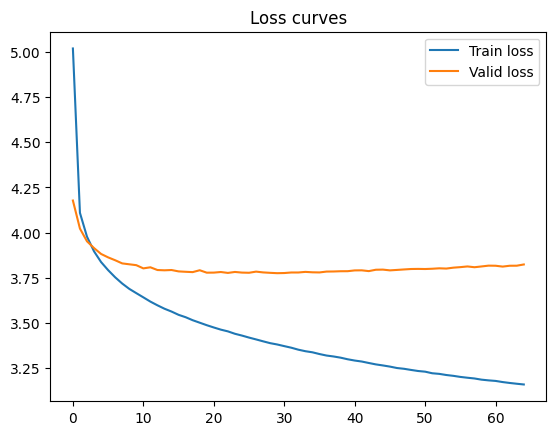

In [ ]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

### 4. Evaluate the model



#### Recap: Perplexity
Recall **perplexity** from the preceding lab:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

#### Computing perplexity

Our model's loss is the average negative loglikelihood of our data over all sequences in the corpus


\begin{align}
\large \text{CE}(p, D) &\large = -\frac{1}{N_{total}}\log_e p(D)
\end{align}



We define perplexity using the **base 2** logarithm but `torch.log` uses base `e`. To **convert to base 2** we use: `log_2 p = log_e p / log_e 2`. Then we can see that perplexity is two to the power of the model loss.



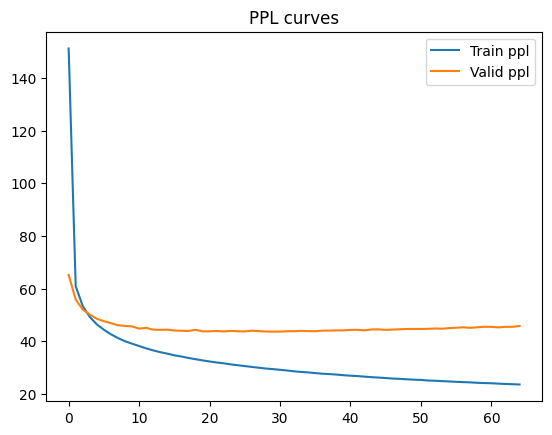

In [ ]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [ ]:
val_ppl = np.min([2**(i[1]/numpy.log(2)) for i in plot_cache])
k = np.argmin([2**(i[1]/numpy.log(2)) for i in plot_cache])
train_ppl = 2**(plot_cache[k][0]/numpy.log(2))

val_df = val_df.append({'model': 'ffnn (n=4)', 'ppl': val_ppl}, ignore_index=True)
train_df = train_df.append({'model': 'ffnn (n=4)', 'ppl': train_ppl}, ignore_index=True)

print('===== Train ======')
print(train_df)
print('==== Validation ======')
print(val_df)

===== Train ======
         model        ppl
0  kenlm (n=2)  39.924842
1  kenlm (n=3)  15.462037
2  kenlm (n=4)   8.919611
3   ffnn (n=4)  29.426679
==== Validation ======
         model        ppl
0  kenlm (n=2)  59.187973
1  kenlm (n=3)  44.977117
2  kenlm (n=4)  43.218831
3   ffnn (n=4)  43.649380


<ipython-input-35-cb38a04cfb84>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_df = val_df.append({'model': 'ffnn (n=4)', 'ppl': val_ppl}, ignore_index=True)
<ipython-input-35-cb38a04cfb84>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'model': 'ffnn (n=4)', 'ppl': train_ppl}, ignore_index=True)


#### Conditional probability queries
We can now query the model for conditional probabilities:

\begin{align}
\large p(x_t|x_{t-1},x_{t-2},x_{t-3})
\end{align}

In [ ]:
import torch

def next_token_probabilities(prefix, token):
    inp = dictionary.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )
    token_id = dictionary.get_id(token)
    p_next_token = torch.softmax(logits, dim=-1)
    return p_next_token[0, token_id]

prefix = '<bos> my pet'

for w in ['dog', 'zebra', 'lion', 'donut', 'velociraptor']:
    prob = next_token_probabilities(prefix, w)
    print('p( %s  | %s )\t= %.3E' % (w, prefix, prob))


p( dog  | <bos> my pet )	= 9.364E-03
p( zebra  | <bos> my pet )	= 7.752E-03
p( lion  | <bos> my pet )	= 9.483E-06
p( donut  | <bos> my pet )	= 1.429E-07
p( velociraptor  | <bos> my pet )	= 1.200E-07




And sort by the highest probability next-tokens:

$\large \texttt{sort}(p(\cdot|\underbrace{x_{<t}}_{\text{prefix}}))$

In [ ]:
def get_top_token_given_prefix(prefix, top=10):
    inp = dictionary.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )

    p_next_token = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_token_ids = torch.topk(p_next_token[0], top)

    for i in range(sorted_token_ids.size(0)):
        print('p( %s  | %s )\t= %.5f' %
              (dictionary.decode_idx_seq([sorted_token_ids[i]])[0],
               prefix,
               sorted_probs[i])
        )

get_top_token_given_prefix('<bos> my pet')  # 'the weather is'  '<bos> <bos> hello'

p( panda  | <bos> my pet )	= 0.10494
p( snake  | <bos> my pet )	= 0.07481
p( is  | <bos> my pet )	= 0.06312
p( lizard  | <bos> my pet )	= 0.05560
p( beta  | <bos> my pet )	= 0.04612
p( iguana  | <bos> my pet )	= 0.03953
p( cat  | <bos> my pet )	= 0.03552
p( skunk  | <bos> my pet )	= 0.03324
p( iguanas  | <bos> my pet )	= 0.02227
p( dogs  | <bos> my pet )	= 0.01664


# Recurrent neural network language model
Recall that in **language modeling**, we want to model the probability of variable length sequences, $$p(x_1,\ldots,x_T)=\prod_{t=1}^T p(x_t|x_{<t}).$$

*Unlike n-gram models*, we will now define a model that allows a **full history** $x_{<t}$.

To do so, we will use a function called a **recurrent neural network** to compute each distribution $p(x_t|x_{<t})$:
\begin{align}
h_t &= f^{\text{RNN}}_{\theta}(x_{t-1}, h_{t-1}) & \mathbb{R}^d\\
s_t &= Wh_t & \mathbb{R}^{\text{|vocab|}}\\
p_{\theta}(x_t|x_{<t}) &= \text{softmax}(s_t) & [0,1]^{\text{|vocab|}}
\end{align}

where $h_t$ is an internal (hidden) state of the model at time step $t$, and $x_t$ is an input at time step $t$.

<img src="https://i.stack.imgur.com/SjnTl.png" style="width:20%">


In the simplest form used in practice, $f_{\theta}^{\text{RNN}}$ is defined as:
 $$f_{\theta}^{\text{RNN}}(x_{t-1}, h_{t-1}) = \text{tanh}(a_t)\\ a_t = b + W \cdot h_{t-1} + U \cdot x_{t-1},$$

but there are other variants (e.g. [GRU](https://arxiv.org/pdf/1406.1078.pdf), [LSTM](https://www.bioinf.jku.at/publications/older/2604.pdf)).

Similar to the n-gram neural network above, the goal at time $t$ is to **predict the next token $x_t$**.

### Pytorch implementation: `RNNCell`

In [ ]:
import torch
from torch.nn import RNNCell

In [ ]:
hidden_size = 16
embedding_dim = 8

rnn_cell = RNNCell(embedding_dim, hidden_size)

In [ ]:
hidden = torch.zeros(1, hidden_size)
print(hidden)
print(hidden.size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([1, 16])


In [ ]:
random_input = torch.rand(1, embedding_dim)
print(random_input)
print(random_input.size())

tensor([[0.4533, 0.1443, 0.4283, 0.6006, 0.5776, 0.5850, 0.2062, 0.2355]])
torch.Size([1, 8])


In [ ]:
hidden = rnn_cell(random_input, hidden)
print(hidden)
print(hidden.size())

tensor([[ 0.5135,  0.1473,  0.0866,  0.1832,  0.1459,  0.0322,  0.1951,  0.1582,
         -0.1480,  0.4039, -0.1565, -0.1623, -0.0057,  0.0756,  0.1281, -0.0506]],
       grad_fn=<TanhBackward0>)
torch.Size([1, 16])


### Pytorch implementation: `RNN`

`RNNCell` is a building block of an RNN model. The Pytorch `RNN` model supports multi-layer networks by creating separate `RNNCell`s for every layer.

`RNN` can also process a whole sequence of data by iteratively applying `RNNCell`.

In [ ]:
from torch.nn import RNNBase, RNN

### 1. Define the model

In [ ]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    def __init__(self, options):
        super().__init__()

        self.lookup = nn.Embedding(
            num_embeddings=options['num_embeddings'],
            embedding_dim=options['embedding_dim'],
            padding_idx=options['padding_idx']
        )
        self.rnn = nn.RNN(
            options['input_size'],
            options['hidden_size'],
            options['num_layers'],
            dropout=options['rnn_dropout'],
            batch_first=True
        )
        self.projection = nn.Linear(
            options['hidden_size'],
            options['num_embeddings']
        )

    def forward(self, token_ids):
        embeddings = self.lookup(token_ids)
        output, hidden = self.rnn(embeddings)
        logits = self.projection(output)
        return logits

### 2. Prepare the data

#### Dataset and Dataloader

See `data_utils.py` for the implementation.

In [ ]:
datasets_ = data_utils.load_personachat('./')
dictionary = data_utils.Dictionary(datasets_, include_valid=True)
datasets_ = data_utils.tokenize_dataset(datasets_, dictionary)

datasets = {}
for split, dataset in datasets_.items():
    datasets[split] = data_utils.TensoredDataset(dataset, dictionary.get_id('<pad>'))

100%|██████████| 16181/16181 [00:03<00:00, 4352.26it/s]



Remember that for model, we want to tackle the following prediction problem:

- The **input** is now a **full sequence**.
- The **output** is the **next token** for each position of the input:



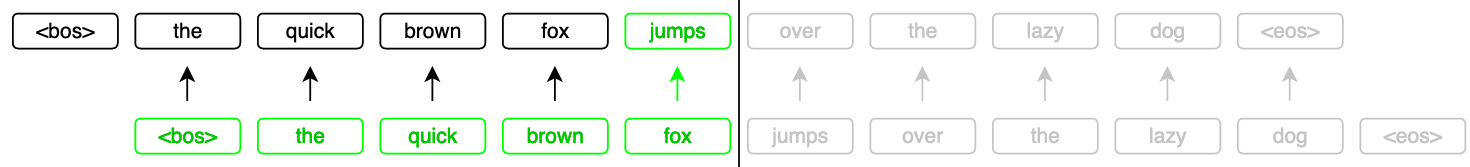

We see that language modeling has a nice property where the labels are simply a 1-shifted version of our input. As long as we ensure that the model has no way of cheating and making use of future labels, it will not be an issue.

In the case of RNNs, there is no cheating because the inputs are processed sequentially. We will see in the case of later models like Transformers that we will need special handling to prevent this.

In [ ]:
inp, out = datasets['train'][0]

print("Input: \n\t%s\n\t(%s)" %
      (inp.data[0], dictionary.decode_idx_seq(inp.data[0])))

print("Output: \n\t%s\n\t(%s)" %
      (out.data[0], dictionary.decode_idx_seq(out.data[0])))

Input: 
	tensor([ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12])
	(['<bos>', 'i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.'])
Output: 
	tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12,  1])
	(['i', 'am', 'doing', 'great', 'except', 'for', 'the', 'allergies', '.', '<eos>'])


#### Pytorch dataloader

In [ ]:
dataloaders = {}
batch_size = 128

for split, dataset in datasets.items():
    dataloaders[split] = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=dataset.pad_collate_fn  # pads the sequences in the batch
    )

#### Padding to handle variable sequence lengths:

In [ ]:
inp, target = next(dataloaders['train'].__iter__())

print("Batch size %s" % str(inp.shape))
print("Batch element 1: \n\t%s\n\t(%s)" %
      (inp.data[0], ' '.join(dictionary.decode_idx_seq(inp.data[0]))))
print("Batch element 2: \n\t%s\n\t(%s)" %
      (inp.data[1], ' '.join(dictionary.decode_idx_seq(inp.data[1]))))

Batch size torch.Size([128, 21])
Batch element 1: 
	tensor([   0,  105,   12,  165, 1199, 1030,   12,  438,   78,  927,  386,  135,
          10,  275,   12,    2,    2,    2,    2,    2,    2])
	(<bos> cool . on summer vacation . reading and writing most of the time . <pad> <pad> <pad> <pad> <pad> <pad>)
Batch element 2: 
	tensor([    0,     4,    54, 13602,  5018,    78,   829,    55,  1610,    12,
           25,    92,  1038,    17,   200,    24,     2,     2,     2,     2,
            2])
	(<bos> i love popping pills and then going hunting . is that dangerous you think ? <pad> <pad> <pad> <pad> <pad>)


### 3. Train the model

#### Initializing model, criterion, and optimizer (similar to the feedforward model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

load_pretrained = True

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load(
        'personachat_rnn_lm.pt',
        map_location=torch.device(current_device)
    )

    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])

else:
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.3

    options = {
        'num_embeddings': len(dictionary),
        'embedding_dim': embedding_size,
        'padding_idx': dictionary.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }
    model = RNNLanguageModel(options).to(current_device)


criterion = nn.CrossEntropyLoss(
    ignore_index=dictionary.get_id('<pad>'),
    reduction='sum'
)

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [ ]:
model

RNNLanguageModel(
  (lookup): Embedding(20089, 256, padding_idx=2)
  (rnn): RNN(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=20089, bias=True)
)

In [ ]:
#### Training loop (same as the feedforward model)

In [ ]:
plot_cache = []

if not load_pretrained:
    for epoch_number in range(100):
        avg_loss = 0
        model.train()

        train_loss_cache = 0
        train_non_pad_tokens_cache = 0

        for i, (inp, target) in enumerate(dataloaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()  # still sum here

            non_pad_tokens = target.view(-1).ne(dictionary.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens

            loss /= non_pad_tokens

            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                avg_loss = train_loss_cache / train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []

        valid_loss_cache = 0
        valid_non_pad_tokens_cache = 0

        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(dataloaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_loss_cache += loss.item()  # still sum here
                non_pad_tokens = target.view(-1).ne(dictionary.get_id('<pad>')).sum().item()

                valid_non_pad_tokens_cache += non_pad_tokens

            avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache

            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

        plot_cache.append((avg_loss, avg_val_loss))


In [ ]:
if load_pretrained:
    plot_cache = model_dict['loss_cache']

### 4. Evaluation

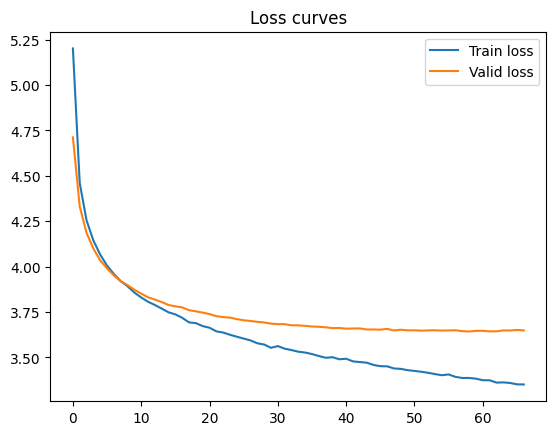

In [ ]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

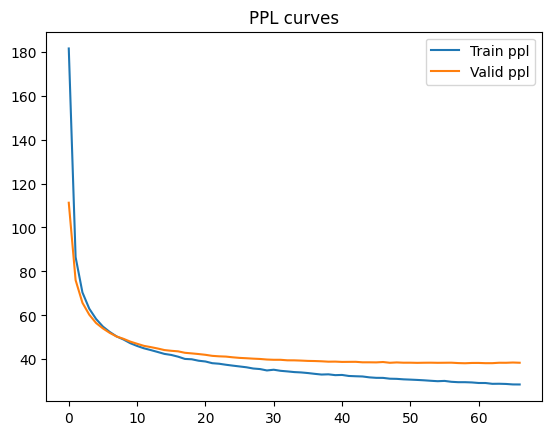

In [ ]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [ ]:
val_ppl = np.min([2**(i[1]/numpy.log(2)) for i in plot_cache])
k = np.argmin([2**(i[1]/numpy.log(2)) for i in plot_cache])
train_ppl = 2**(plot_cache[k][0]/numpy.log(2))

val_df = val_df.append({'model': 'rnn ', 'ppl': val_ppl}, ignore_index=True)
train_df = train_df.append({'model': 'rnn ', 'ppl': train_ppl}, ignore_index=True)

print('===== Train ======')
print(train_df)
print('==== Validation ======')
print(val_df)

===== Train ======
         model        ppl
0  kenlm (n=2)  39.924842
1  kenlm (n=3)  15.462037
2  kenlm (n=4)   8.919611
3   ffnn (n=4)  29.426679
4         rnn   29.582432
==== Validation ======
         model        ppl
0  kenlm (n=2)  59.187973
1  kenlm (n=3)  44.977117
2  kenlm (n=4)  43.218831
3   ffnn (n=4)  43.649380
4         rnn   38.204541


<ipython-input-56-9b11109afe1c>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_df = val_df.append({'model': 'rnn ', 'ppl': val_ppl}, ignore_index=True)
<ipython-input-56-9b11109afe1c>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'model': 'rnn ', 'ppl': train_ppl}, ignore_index=True)


### Conditional probability queries

We can query different probabilities:

$\large p(\underbrace{x_t}_{\text{token}}|\underbrace{x_{<t}}_{\text{prefix}})$

In [ ]:
import torch

def next_token_probabilities(prefix, token):
    inp = dictionary.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )

    token_id = dictionary.get_id(token)
    p_next_token = torch.softmax(logits[0, -1], dim=-1)
    return p_next_token[token_id]

prefix = '<bos> i have a'

for w in ['dog', 'zebra', 'donut', 'velociraptor']:
    prob = next_token_probabilities(prefix, w)
    print('p( %s  | %s )\t= %.3E' % (w, prefix, prob))


p( dog  | <bos> i have a )	= 6.960E-02
p( zebra  | <bos> i have a )	= 1.633E-04
p( donut  | <bos> i have a )	= 1.039E-05
p( velociraptor  | <bos> i have a )	= 2.267E-07




And sort by the highest probability next-tokens:

$\large \texttt{sort}(p(\cdot|\underbrace{x_{<t}}_{\text{prefix}}))$

In [ ]:
def get_top_token_given_prefix(prefix, top=10):
    inp = dictionary.encode_token_seq(prefix.split(' '))
    with torch.no_grad():
        model.eval()
        logits = model(
            torch.tensor([inp], dtype=torch.long).to(current_device)
        )

    p_next_token = torch.softmax(logits[0, -1], dim=-1)
    sorted_probs, sorted_token_ids = torch.topk(p_next_token, top)

    for i in range(sorted_token_ids.size(0)):
        print('p( %s  | %s )\t= %.5f' %
              (dictionary.decode_idx_seq([sorted_token_ids[i]])[0],
               prefix,
               sorted_probs[i])
        )

get_top_token_given_prefix('<bos> the weather is')

p( great  | <bos> the weather is )	= 0.09953
p( nice  | <bos> the weather is )	= 0.07859
p( beautiful  | <bos> the weather is )	= 0.06185
p( fun  | <bos> the weather is )	= 0.05039
p( good  | <bos> the weather is )	= 0.04573
p( awesome  | <bos> the weather is )	= 0.04308
p( cool  | <bos> the weather is )	= 0.04212
p( my  | <bos> the weather is )	= 0.03604
p( a  | <bos> the weather is )	= 0.02892
p( so  | <bos> the weather is )	= 0.02230


### Generation (Sampling)

Finally, we can generate sentences using the model's conditional distribution:

            context = [<bos>]
            until <eos> is generated:
                wt ~ p(wt | context)
                context += [wt]
                
                
Here, the `~` symbol stands for sampling from a categorical distribution.

In [ ]:
import torch

def sample(model, prefix, num_samples, temperature=1.0, max_len=50):
    inp = torch.tensor([
        dictionary.encode_token_seq(prefix.split(' '))
    ], dtype=torch.long).to(current_device).repeat([num_samples, 1])

    sampled = [prefix.split(' ') for _ in range(num_samples)]
    done = torch.tensor([False for _ in range(num_samples)])
    hidden = None

    with torch.no_grad():
        model.eval()
        for t in range(max_len):
            logits, hidden = step(model, inp, hidden)
            logits_ = (logits[:, -1, :] / temperature)
            inp = logits_.softmax(-1).multinomial(1)
            for i in range(num_samples):
                tok_ti = dictionary.get_token(inp[i, 0].item())
                if tok_ti == '<eos>' and not done[i]:
                    done[i] = True
                    sampled[i].append(tok_ti)
                elif not done[i]:
                    sampled[i].append(tok_ti)
                else:
                    pass
            if done.sum() == num_samples:
                break

    return sampled

def step(rnn, token_ids, hidden):
    embeddings = rnn.lookup(token_ids)
    output, hidden = rnn.rnn(embeddings, hidden)
    logits = rnn.projection(output)
    return logits, hidden


prefix = '<bos> i have a'

for temp in [1.0, 0.5, 0.1]:
    print("Temperature %.2f" % temp)
    samples = sample(model, prefix, 5, temperature=temp)
    for s in samples:
        print(' '.join(s))
    print()

Temperature 1.00
<bos> i have a tender twice and apples a few living on my hands . <eos>
<bos> i have a cake as well though . <eos>
<bos> i have a job at a grocery store . i do crafts employment on my navy lane . <eos>
<bos> i have a church amd ! <eos>
<bos> i have a small iq in helping . war i wanted to do that more fast . <eos>

Temperature 0.50
<bos> i have a degree in accounting . <eos>
<bos> i have a job in the city , but i have a job at a store . <eos>
<bos> i have a cat named radar . <eos>
<bos> i have a lot of friends . <eos>
<bos> i have a dog named toto . <eos>

Temperature 0.10
<bos> i have a lot of friends . <eos>
<bos> i have a dog , he is a cat . <eos>
<bos> i have a dog named toto . <eos>
<bos> i have a cat named cow . <eos>
<bos> i have a dog , he is a teacher . <eos>



In [ ]:
# Saving the model
if False:
    torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, './persona_rnn_lm.pt')

# Large-scale Language Modeling.

The language model above is relatively small in terms of the number of parameters, and is trained on a (very) small dataset.

Recently, researchers have trained **large-scale language models** on **large amounts of data**, resulting in improved language modeling and generation ability.

We take one from FAIR's recently published Open Pretrained Transformers (OPT) [[paper]([[paper](https://arxiv.org/pdf/2205.01068.pdf)] as an example here. OPT is a suite of decoder-only pre-trained transformers ranging from 125M to 175B parameters. We won't currently discuss the details of this model, but we can easily **use a pre-trained version to generate text**,

### [facebook/opt-350m](https://huggingface.co/facebook/opt-350m)

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline, set_seed

set_seed(32)
generator = pipeline('text-generation',
                     model="facebook/opt-350m",
                     do_sample=True,
                     num_return_sequences=5, max_length = 30)
generator("My favorite food is")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'generated_text': 'My favorite food is burgers\nI like beef, turkey, and pork. I usually eat a chicken sub.'},
 {'generated_text': 'My favorite food is chicken tenders, and the worst are the ones with the most cheese on them.\nI love the Cheese Grater, but'},
 {'generated_text': "My favorite food is to be sure the rest of the world know what is in my head... I can't eat without the idea that I am cooking"},
 {'generated_text': 'My favorite food is tuna.\nCan confirm, have tuna.\nTuna is the best food in the world\nNow that would be a big'},
 {'generated_text': "My favorite food is sushi. The food here is good but it's not very good and the ingredients are usually a bit excessive when compared to the quality"}]

### [facebook/opt-2.7b](https://huggingface.co/facebook/opt-2.7b)

We can also load even very large checkpoints by leveraging the dispatching utility in colab. This should handle up to 11B in Colab Free, and 30B in colab Pro. We will demonstrate how to load the **facebook/opt-2.7b** checkpoint here.


Ref: https://colab.research.google.com/drive/14wnxMvD9zsiBQo2FtTpxn6w2cpXCcb-7#scrollTo=R94R2YaeQMQS&uniqifier=1

In [ ]:
! pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 13.1 MB/s eta 0:00:00


In [ ]:
# Download the Weights
from huggingface_hub import hf_hub_download

checkpoint = 'facebook/opt-2.7b'
weights_path = hf_hub_download(checkpoint, "pytorch_model.bin")


We then instantiate a configuration, and we load the model from the config inside the `init_empty_weights` decorator.

This decorate instantiates an empty shell with the model. This does not actually load or instantiate any weight, only the shapes.

This unties the weights, so we manually retie the weights afterwards.

In [ ]:
from accelerate import init_empty_weights, load_checkpoint_and_dispatch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

config = AutoConfig.from_pretrained(checkpoint)
# Initializes an empty shell with the model. This is instant and does not take any RAM.
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)
# Initialize the model under the previous context manager breaks the tied weights.
model.tie_weights()

We load the checkpoint that is saved on disk and we dispatch it to the devices. At no point is the checkpoint fully loaded in RAM; only parts of it to be dispatched to each device.






In [ ]:
# Load the checkpoint and dispatch it to the right devices
model = load_checkpoint_and_dispatch(
    model, weights_path, device_map="auto", no_split_module_classes=["OPTDecoderLayer"]
)

Finally, we create a prompt to generate from and we generate a text from it.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-6.7b')
inputs = tokenizer("My favorite food is", return_tensors="pt")

output = model.generate(inputs["input_ids"].to(0),
                        num_return_sequences=5,
                        max_length = 30,
                        do_sample=True)


In [ ]:
for out in output:
  print(tokenizer.decode(out.tolist()))

</s>My favorite food is a fried egg that has been fried twice before it reaches my hand. Yup
Do you like the hard boiled egg y
</s>My favorite food is chicken parmesan.  *It's really good*
I am not in favor of parmesan chicken. Please
</s>My favorite food is pizza.  Edit: I have to say the pizza I've been eating the few nights is pretty damn good. I also
</s>My favorite food is probably spaghetti with egg noodles. The most comforting thing on planet earth IMO.
Egg noodles sound like they may be
</s>My favorite food is ice cream.
Why do you love ice cream so much?
The sweet vanilla taste, I could eat it all day
